In [1]:
import pandas as pd
import numpy as np
import math

env = "Varinia"

In [2]:
if env == "Sky":
    data_path_1='../Expert_response/all_HIT_answer.csv'
    data_path_2='../Expert_response/master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'

else:
    data_path_1=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\all_HIT_answer.csv'
    data_path_2=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\master_all_responses_May-14-2023_to_May-18-2023_Dan.csv'
    data_path_3=r'C:\Users\varin\PycharmProjects\amazon-lameness-phase2\Expert_response\gs_response_Jun-04-2023.csv'

df_1= pd.read_csv(data_path_1)
df_2= pd.read_csv(data_path_2)
df_3= pd.read_csv(data_path_3)

In [3]:
def process_data(df_1, df_2):
    # Remove all positive and negative attention checks, keep only 1 copy of the positive attention check
    all_test_q = df_1[(df_1['question_type'] != "neg_attention") & (df_1['question_type'] != "pos_attention_easy")].copy()
    pos_attention_q = df_1[df_1['question_type'] == "pos_attention_easy"].head(1).copy()

    # Concatenate the dataframes and reset the index
    all_q = pd.concat([all_test_q, pos_attention_q], ignore_index=True)
    all_q.reset_index(drop=True, inplace=True)

    # Select the desired columns and convert question_num to int
    all_q2 = all_q[['cow_L', 'cow_R', 'question_num', 'HIT']].copy()
    all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)

    # Select the columns for response dataframe
    all_q_col = [f"q{i}" for i in range(1, 13)]
    all_col = all_q_col.copy()
    all_col.append('HIT')

    # Get the response dataframe
    response = df_2[all_col].copy()

    return all_q2, response


In [4]:
def reshape_and_remove_nan(df):
    df_melted = df.melt(id_vars='HIT',
                        value_vars=['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12'],
                        var_name='question_num',
                        value_name='response')
    df_melted['question_num'] = df_melted['question_num'].str[1:].astype(int)
    df_melted = df_melted.dropna()
    return df_melted

In [5]:
def process_and_merge(df_1, df_2):
    all_q2, response = process_data(df_1, df_2)
    response_melted = reshape_and_remove_nan(response)
    merged_df = all_q2.merge(response_melted, on=['HIT', 'question_num'], how='inner')
    merged_df2 = merged_df[['cow_L', 'cow_R', 'response']]

    return merged_df2


In [6]:
final_df=process_and_merge(df_1, df_2)
display(final_df)

C:\Users\varin\AppData\Local\Temp\ipykernel_37920\1855475665.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  all_q2.loc[:, 'question_num'] = all_q2['question_num'].str[1:].astype(int)


,cow_L,cow_R,response
0,6029,7138,-1.0
1,5087,4008,-3.0
2,6092,7114,0.0
3,6053,6088,1.0
4,4035,7060,-1.0
...,...,...,...
430,5087,5064,-1.0
431,6046,4035,2.0
432,7109,7153,-1.0
433,6068,5118,-1.0


In [7]:
def simple_responses(df):
    N=df.shape[0]
    matrix=[]
    for i in range(N):
        aux_df=df.iloc[[i]]
        cow_L=aux_df.at[i,'cow_L']
        cow_R=aux_df.at[i,'cow_R']
        response=aux_df.at[i,'response']
        if response==0:
            row=np.concatenate(([cow_L],[cow_R],[0]))
        elif response<0:
            row=np.concatenate(([cow_L],[cow_R],[-1]))
        else:
            row=np.concatenate(([cow_L],[cow_R],[1]))
        matrix.append(row.tolist())
    new_df=pd.DataFrame(matrix)
    new_df.columns=['cow_L', 'cow_R', 'response']

    return new_df

In [8]:
responses=simple_responses(final_df)
display(responses)

,cow_L,cow_R,response
0,6029,7138,-1
1,5087,4008,-1
2,6092,7114,0
3,6053,6088,1
4,4035,7060,-1
...,...,...,...
430,5087,5064,-1
431,6046,4035,1
432,7109,7153,-1
433,6068,5118,-1


In [9]:
def list_cows(df):
    first_cow=df.loc[0,'cow_L']
    aux_df=df[df['cow_L']==first_cow]
    cows_1=list(aux_df['cow_R'])
    aux_df=df[df['cow_R']==first_cow]
    cows_2=list(aux_df['cow_L'])
    for i in cows_2:
        cows_1.append(i)
    cows_1.append(first_cow)
    return cows_1

In [10]:
cow_order=list_cows(responses)
print(cow_order)
print(len(cow_order))

[7138, 6062, 8083, 7128, 6025, 7153, 4035, 6092, 4026, 6086, 6094, 7060, 7116, 6088, 7163, 5064, 6095, 7136, 7114, 4008, 7064, 6053, 5118, 6096, 7109, 6046, 6068, 5087, 7045, 6029]
30


In [29]:
def matrix_comparison(df):
    cow_order=list_cows(df)
    num_cows=len(cow_order)
    data_comp=np.zeros( (num_cows, num_cows) )
    for i in range(num_cows):
        for j in range(num_cows):
            if (i==j):
                data_comp[i][j]=np.nan
            else:
                aux=df[(df['cow_L']==cow_order[i])|(df['cow_R']==cow_order[i])]
                aux=aux[(aux['cow_L']==cow_order[j])|(aux['cow_R']==cow_order[j])]
                #print(aux)
                cow_L=aux['cow_L'].to_numpy()
                cow_R=aux['cow_R'].to_numpy()
                response=aux['response'].to_numpy()
                if(response[0]==0):
                    data_comp[i][j]=0
                else:        
                    if(cow_L[0]==cow_order[i]):
                        if(response[0]<0):
                            data_comp[i][j]=1
                        else: 
                            data_comp[i][j]=-1
                    else: #aux['cow_L']==cow_order[j]
                        if(response[0]<0):
                            data_comp[i][j]=-1
                        else: 
                            data_comp[i][j]=1
    data_comp = pd.DataFrame(data_comp)
    #Rename rows and cols with cow names in original order
    row_dic= {i: str(num) for i, num in enumerate(cow_order)}
    col_name = [str(num) for num in cow_order]
    data_comp = data_comp.rename(index=row_dic)
    data_comp.columns = col_name
    # Randomize row order
    random_indices = np.random.permutation(data_comp.index)
    data_comp = data_comp.loc[random_indices, random_indices]
    #Change type to fit cow_order format
    new_cow_order = [int(x) for x in random_indices]
    #Re set row&col names
    new_indices = range(len(data_comp.index))
    data_comp = data_comp.rename(index=dict(zip(data_comp.index, new_indices)),
                                         columns=dict(zip(data_comp.columns, new_indices)))
    return data_comp, new_cow_order

In [31]:
data_comparison,new_cow_order = matrix_comparison(responses)
display(data_comparison,new_cow_order)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,NaN,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
1,-1.0,NaN,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,...,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0
2,-1.0,-1.0,NaN,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0
3,-1.0,-1.0,0.0,NaN,-1.0,-1.0,-1.0,1.0,1.0,-1.0,...,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0
4,-1.0,-1.0,1.0,1.0,NaN,-1.0,0.0,0.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
5,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0
6,-1.0,-1.0,1.0,1.0,0.0,-1.0,NaN,0.0,-1.0,0.0,...,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0
7,-1.0,-1.0,1.0,-1.0,0.0,-1.0,0.0,NaN,-1.0,0.0,...,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0
8,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,NaN,-1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,0.0
9,-1.0,1.0,1.0,1.0,1.0,-1.0,0.0,0.0,1.0,NaN,...,-1.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0,-1.0,1.0


[6088,
 6086,
 7045,
 7138,
 7109,
 7116,
 6096,
 5118,
 6068,
 7128,
 7064,
 5087,
 4035,
 6046,
 7060,
 4008,
 6053,
 6025,
 4026,
 7153,
 6095,
 6062,
 7163,
 8083,
 6094,
 5064,
 7136,
 6092,
 7114,
 6029]

In [32]:

def mergeSort(lst,comp,data_comparison):
    if len(lst) > 1:
        r = len(lst)//2
        L = lst[:r]
        M = lst[r:]
        L,comp=mergeSort(L,comp,data_comparison)
        M,comp=mergeSort(M,comp,data_comparison)
        lst=L+M
        i = j = k = 0

        while i < len(L) and j < len(M):
            comp += 1
            if data_comparison[L[i][0]][M[j][0]]==1 :
                lst[k] = L[i]
                i += 1
            else:
                lst[k] = M[j]
                j += 1
            k += 1

        while i < len(L):
            lst[k] = L[i]
            i += 1
            k += 1

        while j < len(M):
            lst[k] = M[j]
            j += 1
            k += 1
    return lst,comp


Cow order in matrix is:
[7109, 6062, 7060, 7163, 7153, 7114, 6096, 6029, 6046, 6025, 7138, 7116, 6068, 4026, 6092, 6086, 5087, 7128, 6095, 7045, 5118, 6094, 7136, 5064, 6088, 4035, 4008, 7064, 6053, 8083]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[7], [4], [9], [3], [10], [2], [12], [14], [19], [0], [13], [8], [17], [29], [20], [15], [5], [18], [1], [6], [28], [27], [26], [22], [24], [23], [11], [21], [16], [25]]
Sorted cows in ascending order is:
[[6029], [7153], [6025], [7163], [7138], [7060], [6068], [6092], [7045], [7109], [4026], [6046], [7128], [8083], [5118], [6086], [7114], [6095], [6062], [6096], [6053], [7064], [4008], [7136], [6088], [5064], [7116], [6094], [5087], [4035]]
Number of comparisons done in merge sort:
196
    merge sorted  GS
0           6029   2
1           7153   2
2 

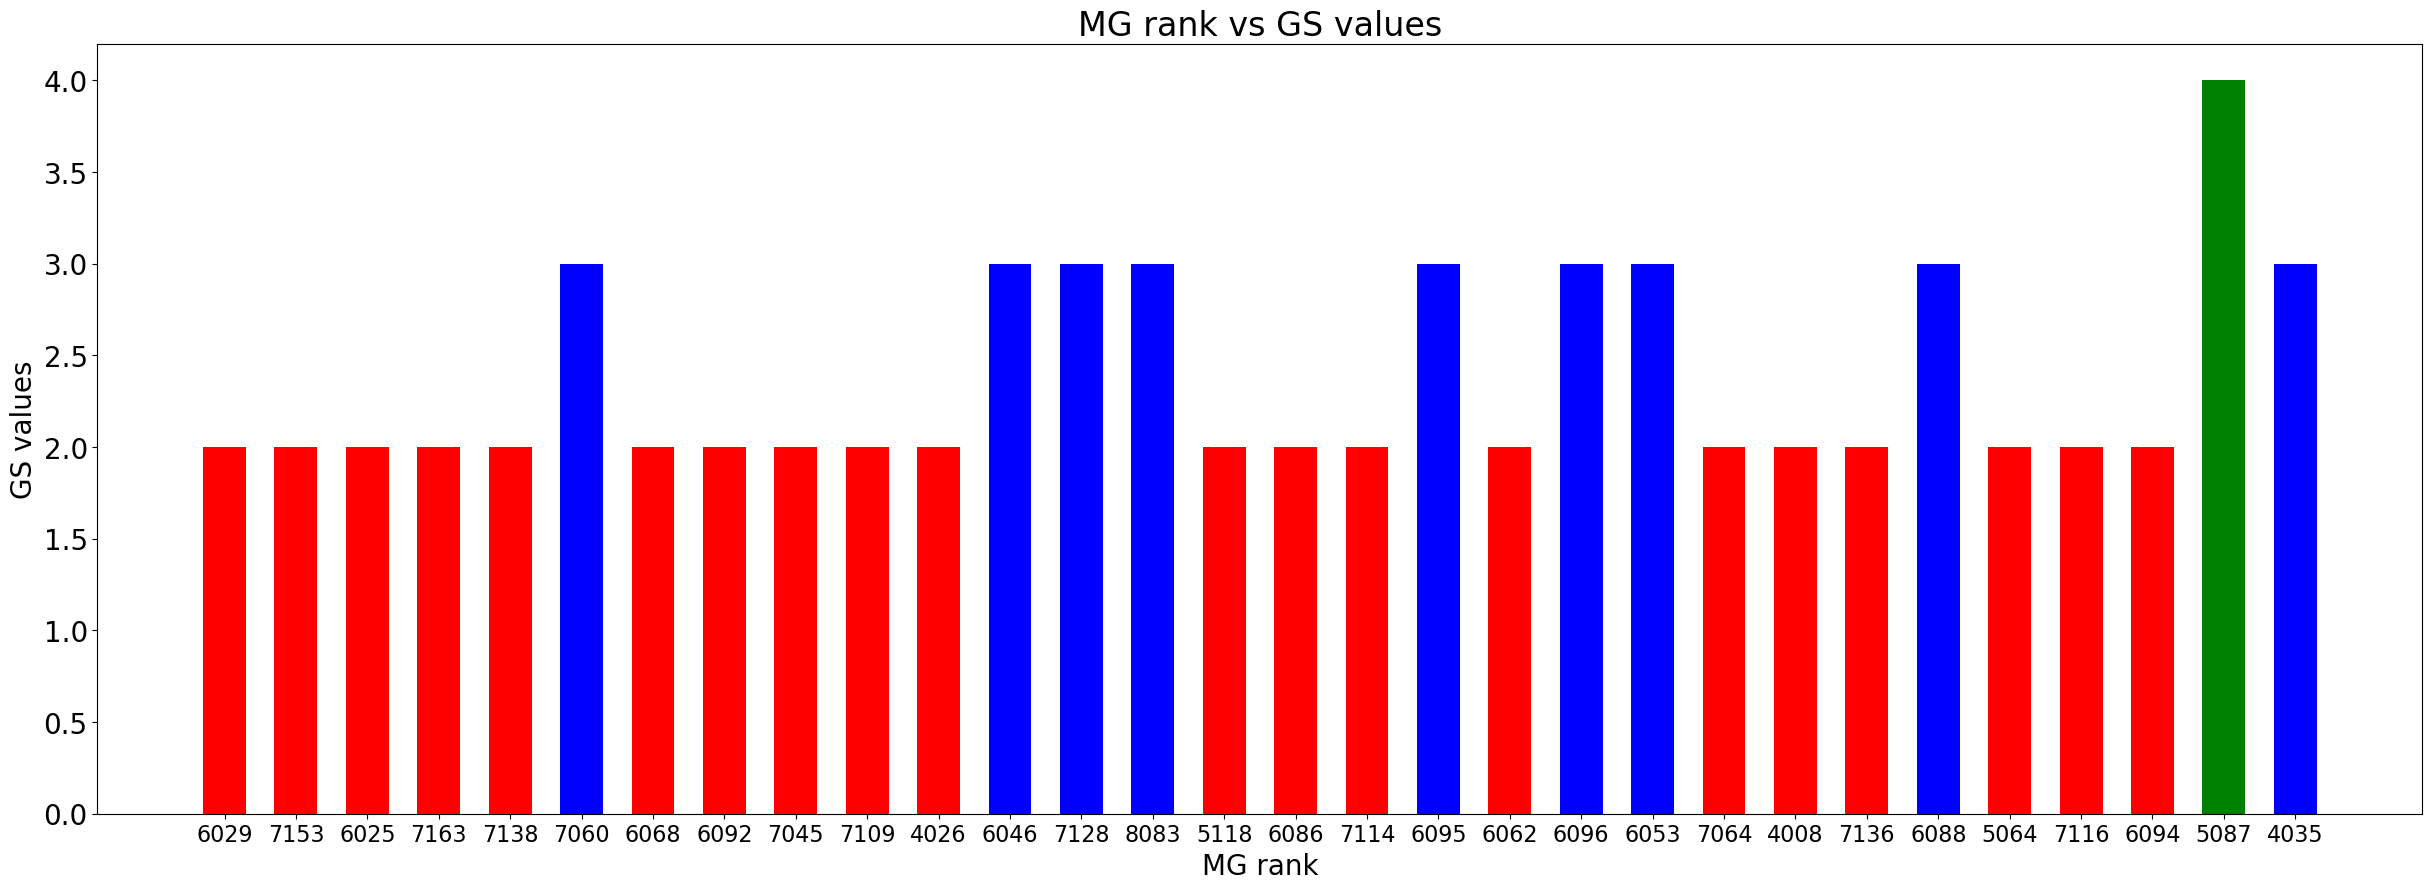

Cow order in matrix is:
[7163, 6086, 6094, 4008, 6088, 4035, 6029, 4026, 6092, 7138, 5064, 7114, 7109, 6046, 7060, 7116, 7064, 7128, 7153, 6062, 5087, 6095, 6096, 8083, 7045, 6068, 6025, 6053, 7136, 5118]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[24], [6], [0], [7], [18], [28], [25], [19], [2], [12], [1], [26], [17], [11], [8], [14], [23], [22], [29], [21], [13], [9], [27], [16], [3], [4], [10], [15], [20], [5]]
Sorted cows in ascending order is:
[[7045], [6029], [7163], [4026], [7153], [7136], [6068], [6062], [6094], [7109], [6086], [6025], [7128], [7114], [6092], [7060], [8083], [6096], [5118], [6095], [6046], [7138], [6053], [7064], [4008], [6088], [5064], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
199
    merge sorted  GS
0           7045   2
1           6029   2
2 

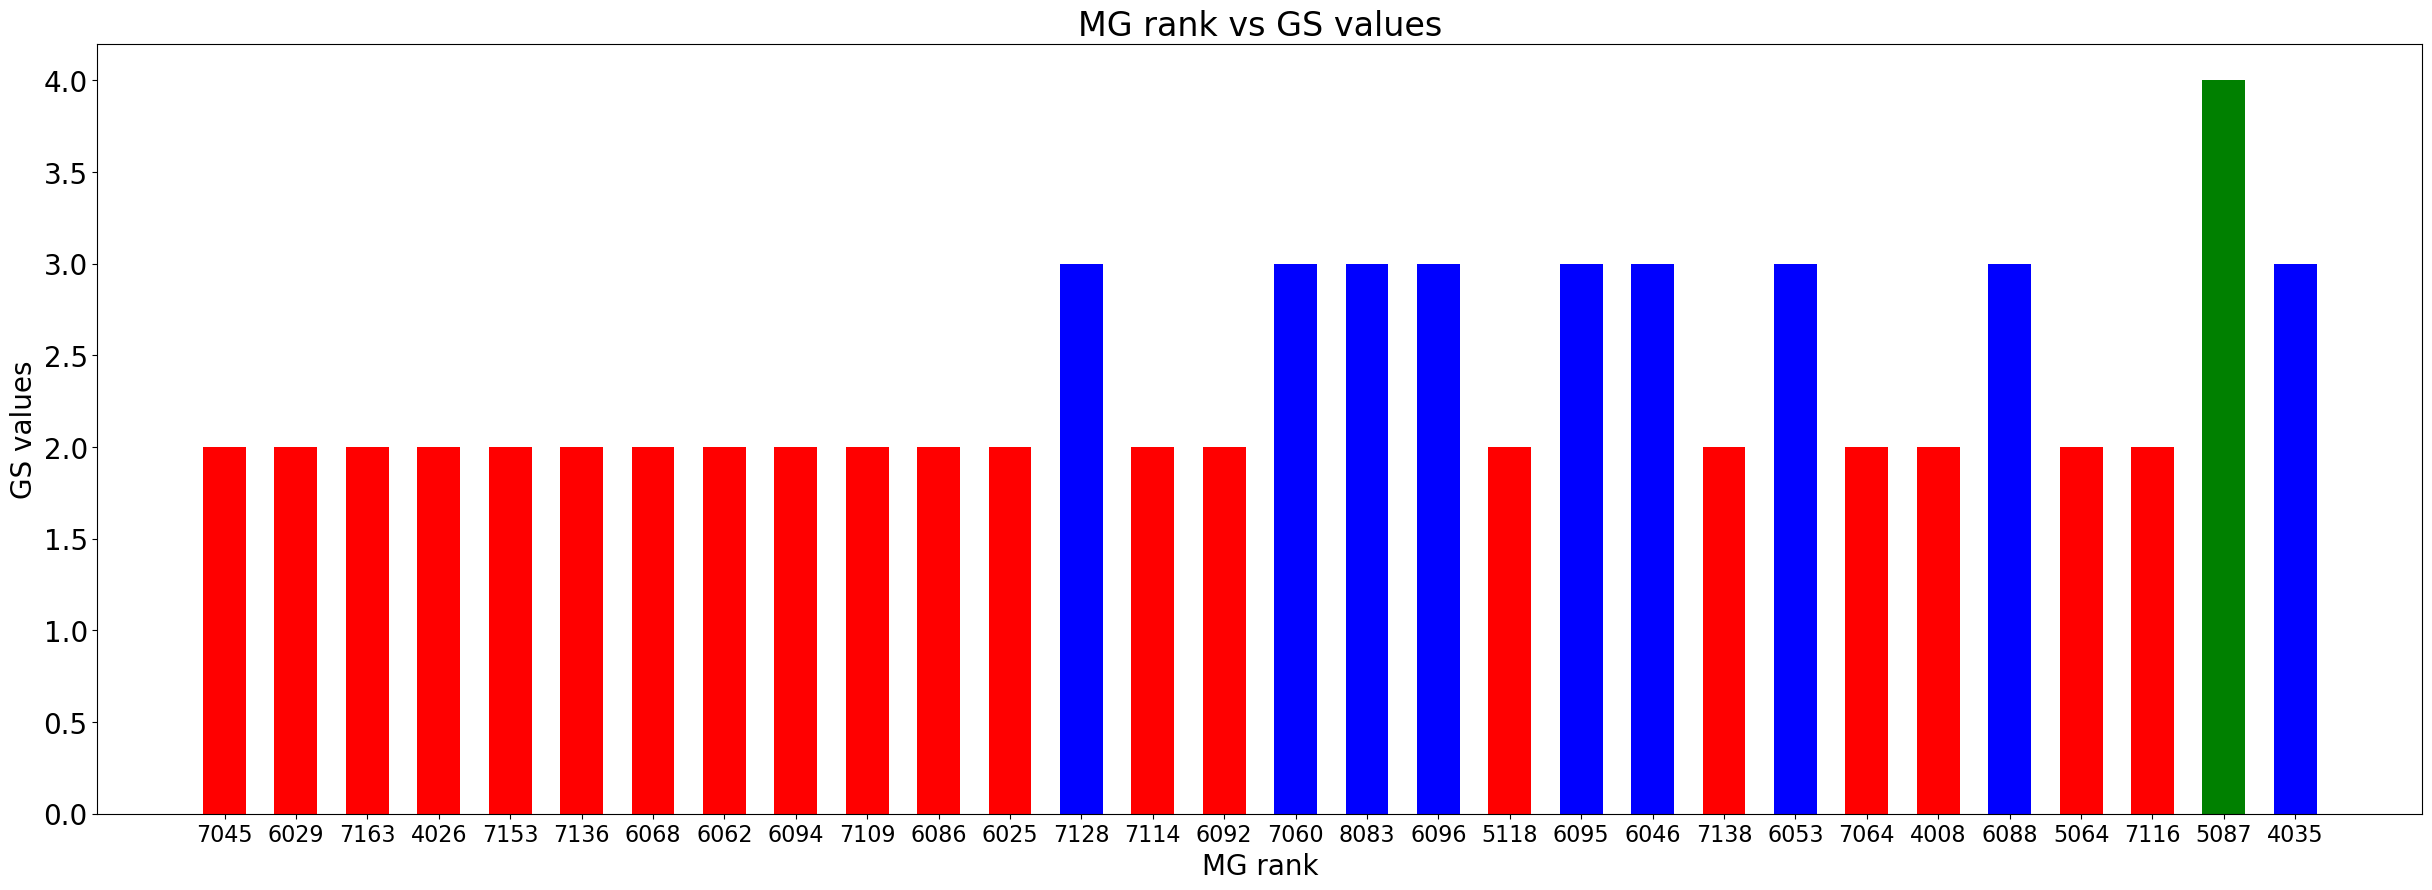

Cow order in matrix is:
[6062, 7136, 6096, 6068, 7116, 6046, 7114, 7109, 6025, 5087, 7163, 7153, 6029, 4008, 5064, 7064, 7045, 4026, 6095, 6094, 7128, 7138, 6086, 8083, 6092, 7060, 6053, 6088, 5118, 4035]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[5], [16], [0], [10], [2], [3], [15], [11], [18], [21], [19], [7], [22], [6], [12], [8], [24], [25], [17], [13], [1], [27], [14], [20], [23], [26], [28], [4], [9], [29]]
Sorted cows in ascending order is:
[[6046], [7045], [6062], [7163], [6096], [6068], [7064], [7153], [6095], [7138], [6094], [7109], [6086], [7114], [6029], [6025], [6092], [7060], [4026], [4008], [7136], [6088], [5064], [7128], [8083], [6053], [5118], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
212
    merge sorted  GS
0           6046   3
1           7045   2
2 

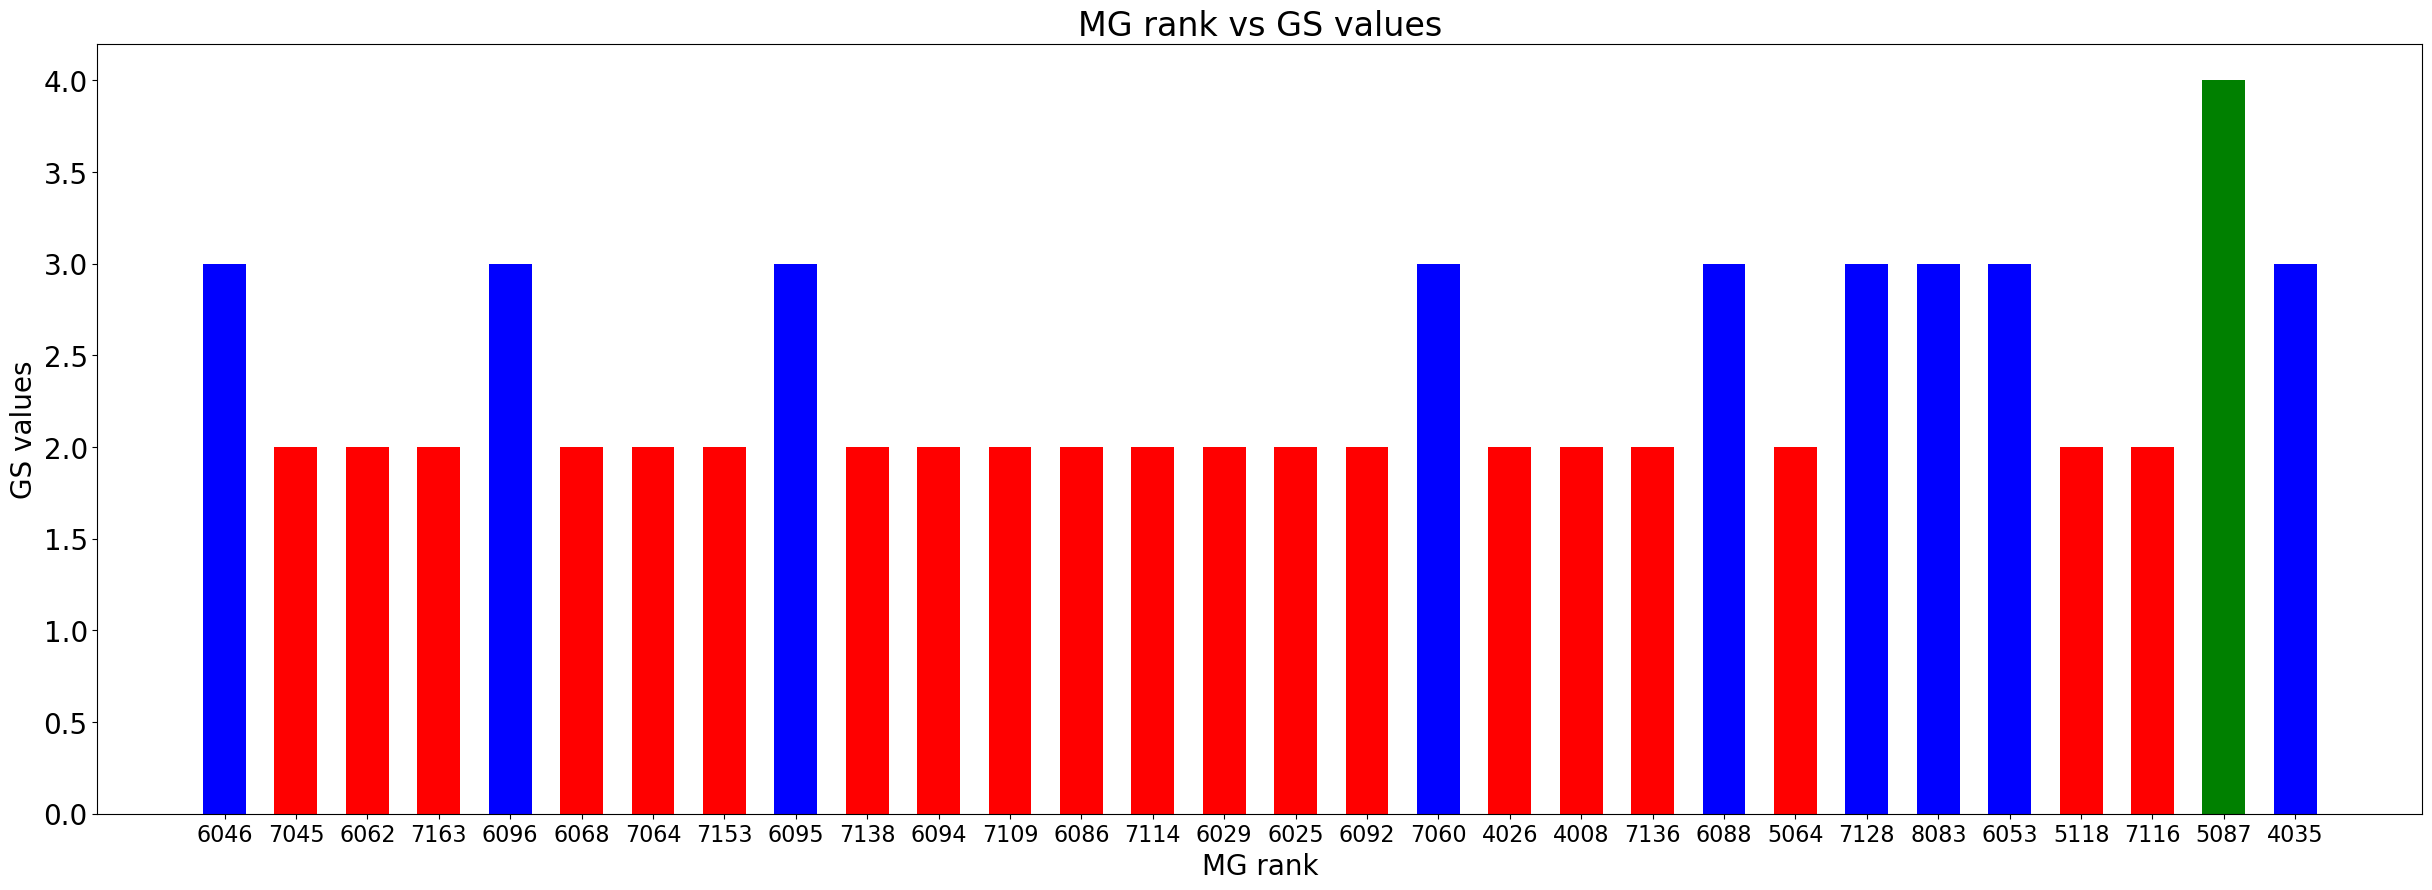

Cow order in matrix is:
[6053, 6094, 7045, 6068, 7138, 6025, 4008, 7060, 5087, 8083, 7116, 6046, 6095, 4026, 7136, 6062, 6029, 6092, 5118, 7128, 7163, 6086, 5064, 7109, 4035, 7153, 6096, 6088, 7114, 7064]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[2], [7], [16], [17], [18], [28], [20], [3], [9], [26], [21], [12], [1], [15], [23], [0], [29], [25], [5], [4], [13], [11], [19], [6], [14], [27], [22], [10], [8], [24]]
Sorted cows in ascending order is:
[[7045], [7060], [6029], [6092], [5118], [7114], [7163], [6068], [8083], [6096], [6086], [6095], [6094], [6062], [7109], [6053], [7064], [7153], [6025], [7138], [4026], [6046], [7128], [4008], [7136], [6088], [5064], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
198
    merge sorted  GS
0           7045   2
1           7060   3
2 

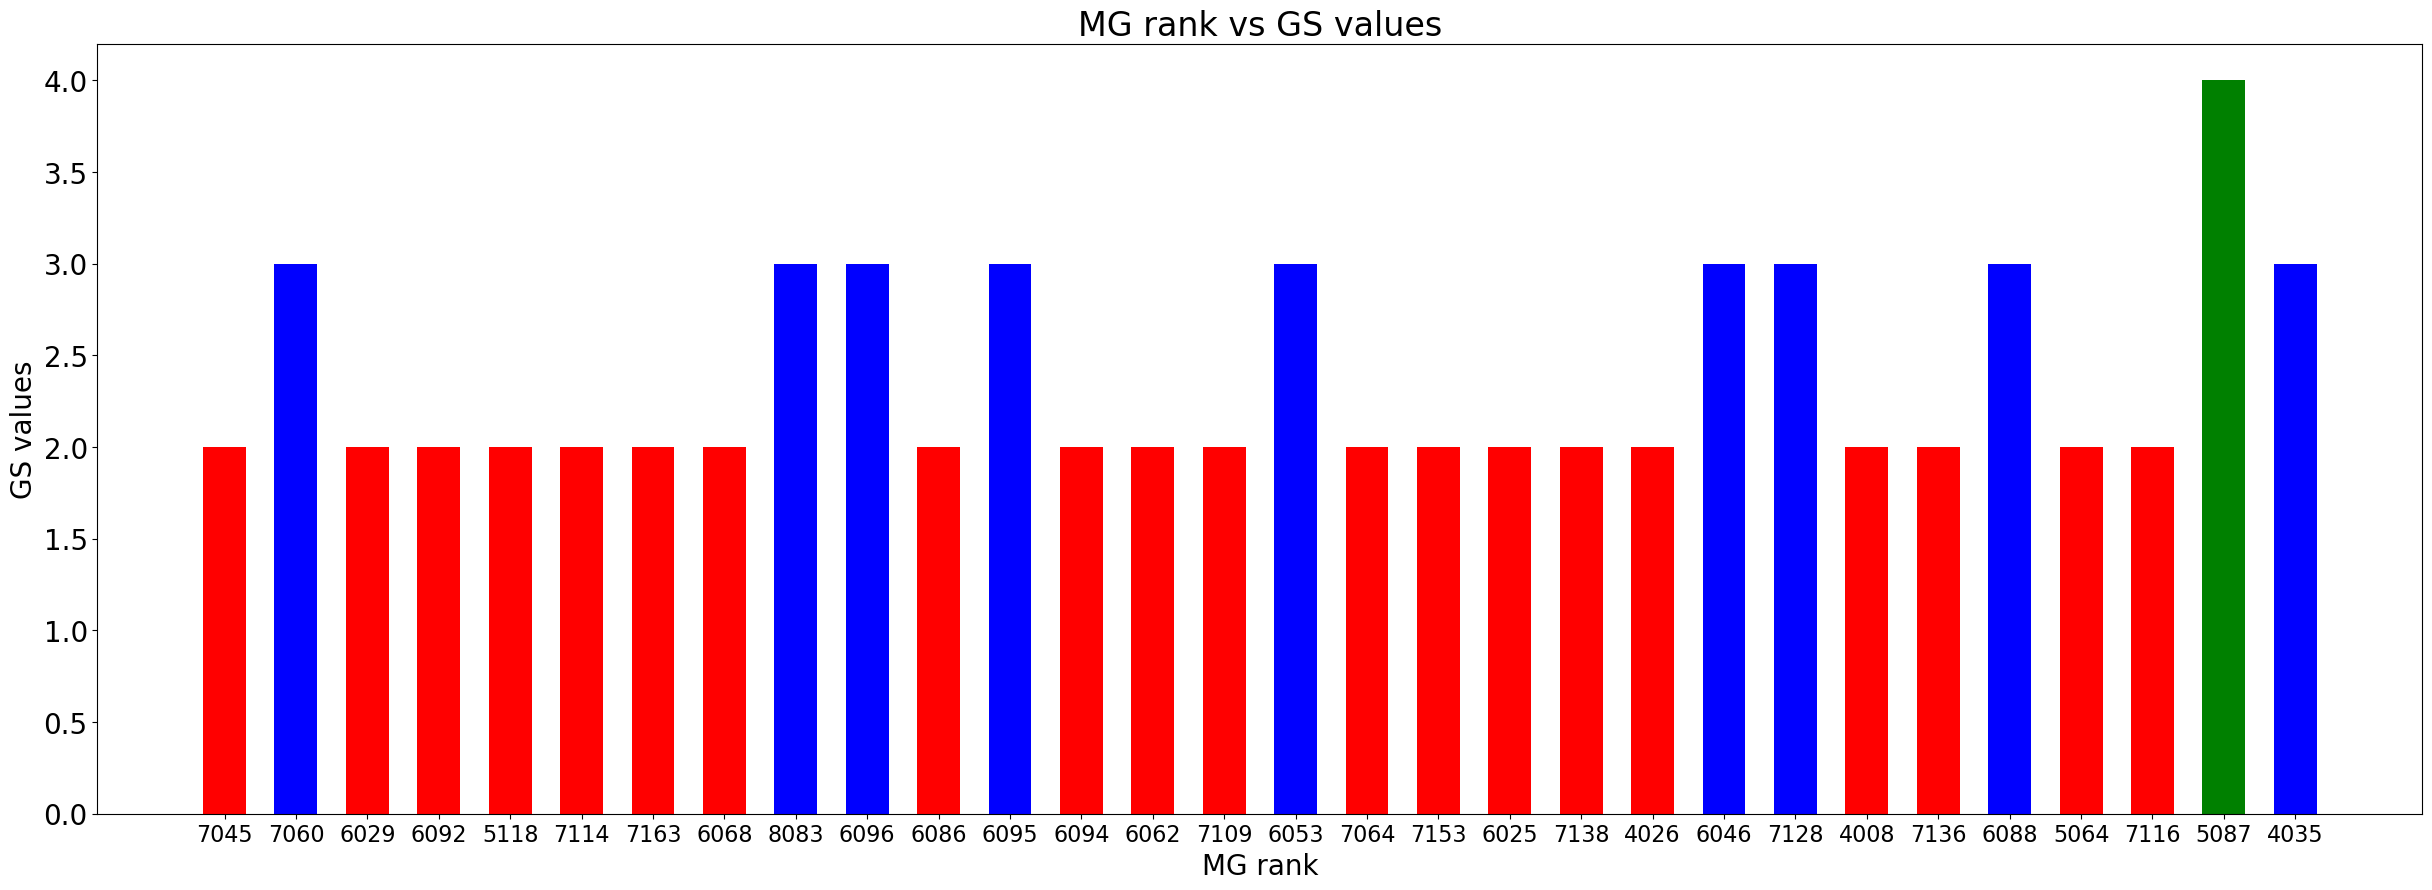

Cow order in matrix is:
[8083, 5118, 6094, 4035, 6046, 6092, 6096, 7128, 7163, 6088, 6086, 6095, 7045, 7114, 7153, 6053, 5087, 7138, 7109, 4008, 6029, 7116, 4026, 7064, 6068, 7060, 5064, 6025, 7136, 6062]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[5], [25], [26], [12], [18], [7], [1], [13], [20], [11], [29], [8], [22], [4], [6], [24], [23], [14], [17], [19], [28], [2], [10], [15], [27], [9], [21], [16], [3], [0]]
Sorted cows in ascending order is:
[[6092], [7060], [5064], [7045], [7109], [7128], [5118], [7114], [6029], [6095], [6062], [7163], [4026], [6046], [6096], [6068], [7064], [7153], [7138], [4008], [7136], [6094], [6086], [6053], [6025], [6088], [7116], [5087], [4035], [8083]]
Number of comparisons done in merge sort:
204
    merge sorted  GS
0           6092   2
1           7060   3
2 

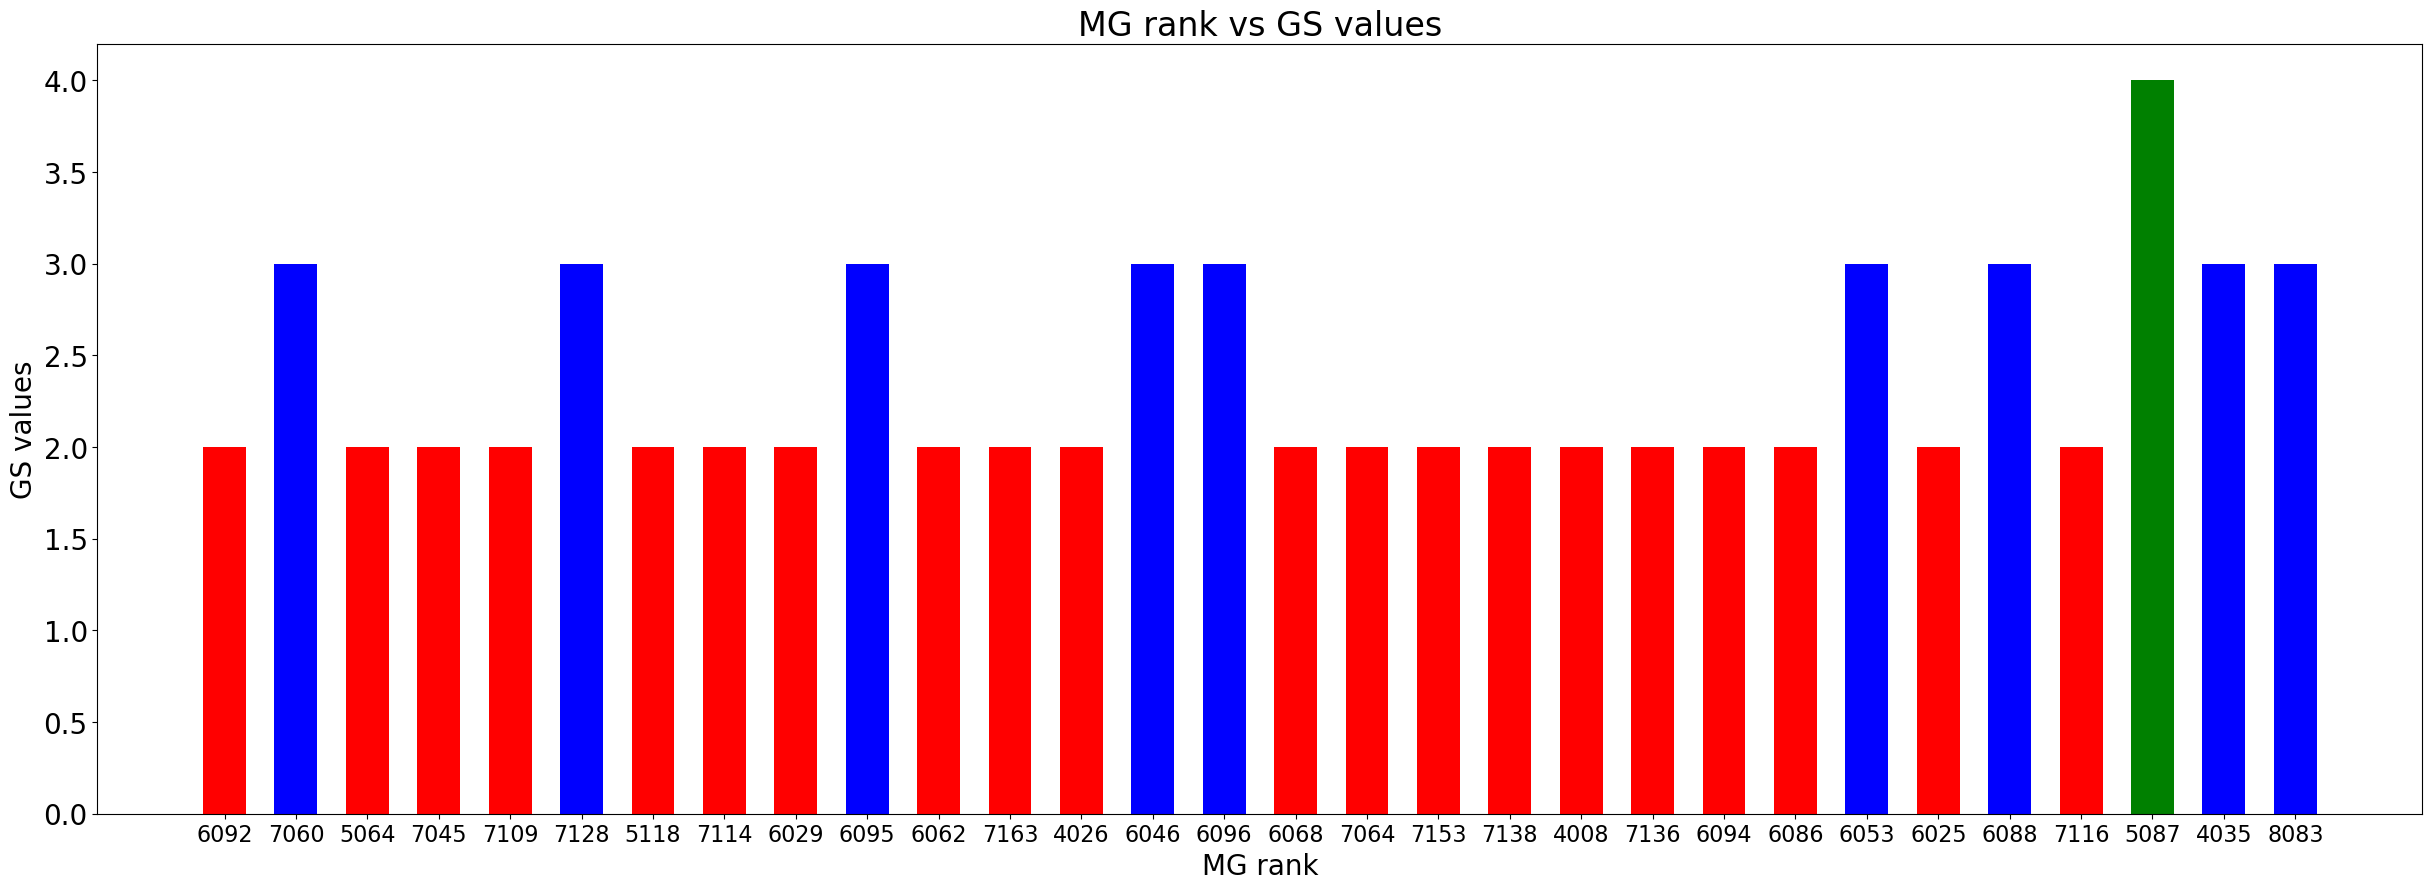

Cow order in matrix is:
[6095, 7114, 8083, 7116, 6068, 6088, 6029, 6053, 7109, 4035, 6062, 6094, 5064, 7136, 7064, 7045, 5118, 7153, 5087, 7060, 7138, 6086, 6025, 6092, 4008, 4026, 7163, 6096, 6046, 7128]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[0], [28], [15], [26], [4], [8], [1], [7], [6], [12], [22], [19], [23], [2], [27], [21], [10], [25], [16], [14], [24], [13], [17], [20], [29], [11], [5], [3], [18], [9]]
Sorted cows in ascending order is:
[[6095], [6046], [7045], [7163], [6068], [7109], [7114], [6053], [6029], [5064], [6025], [7060], [6092], [8083], [6096], [6086], [6062], [4026], [5118], [7064], [4008], [7136], [7153], [7138], [7128], [6094], [6088], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
207
    merge sorted  GS
0           6095   3
1           6046   3
2 

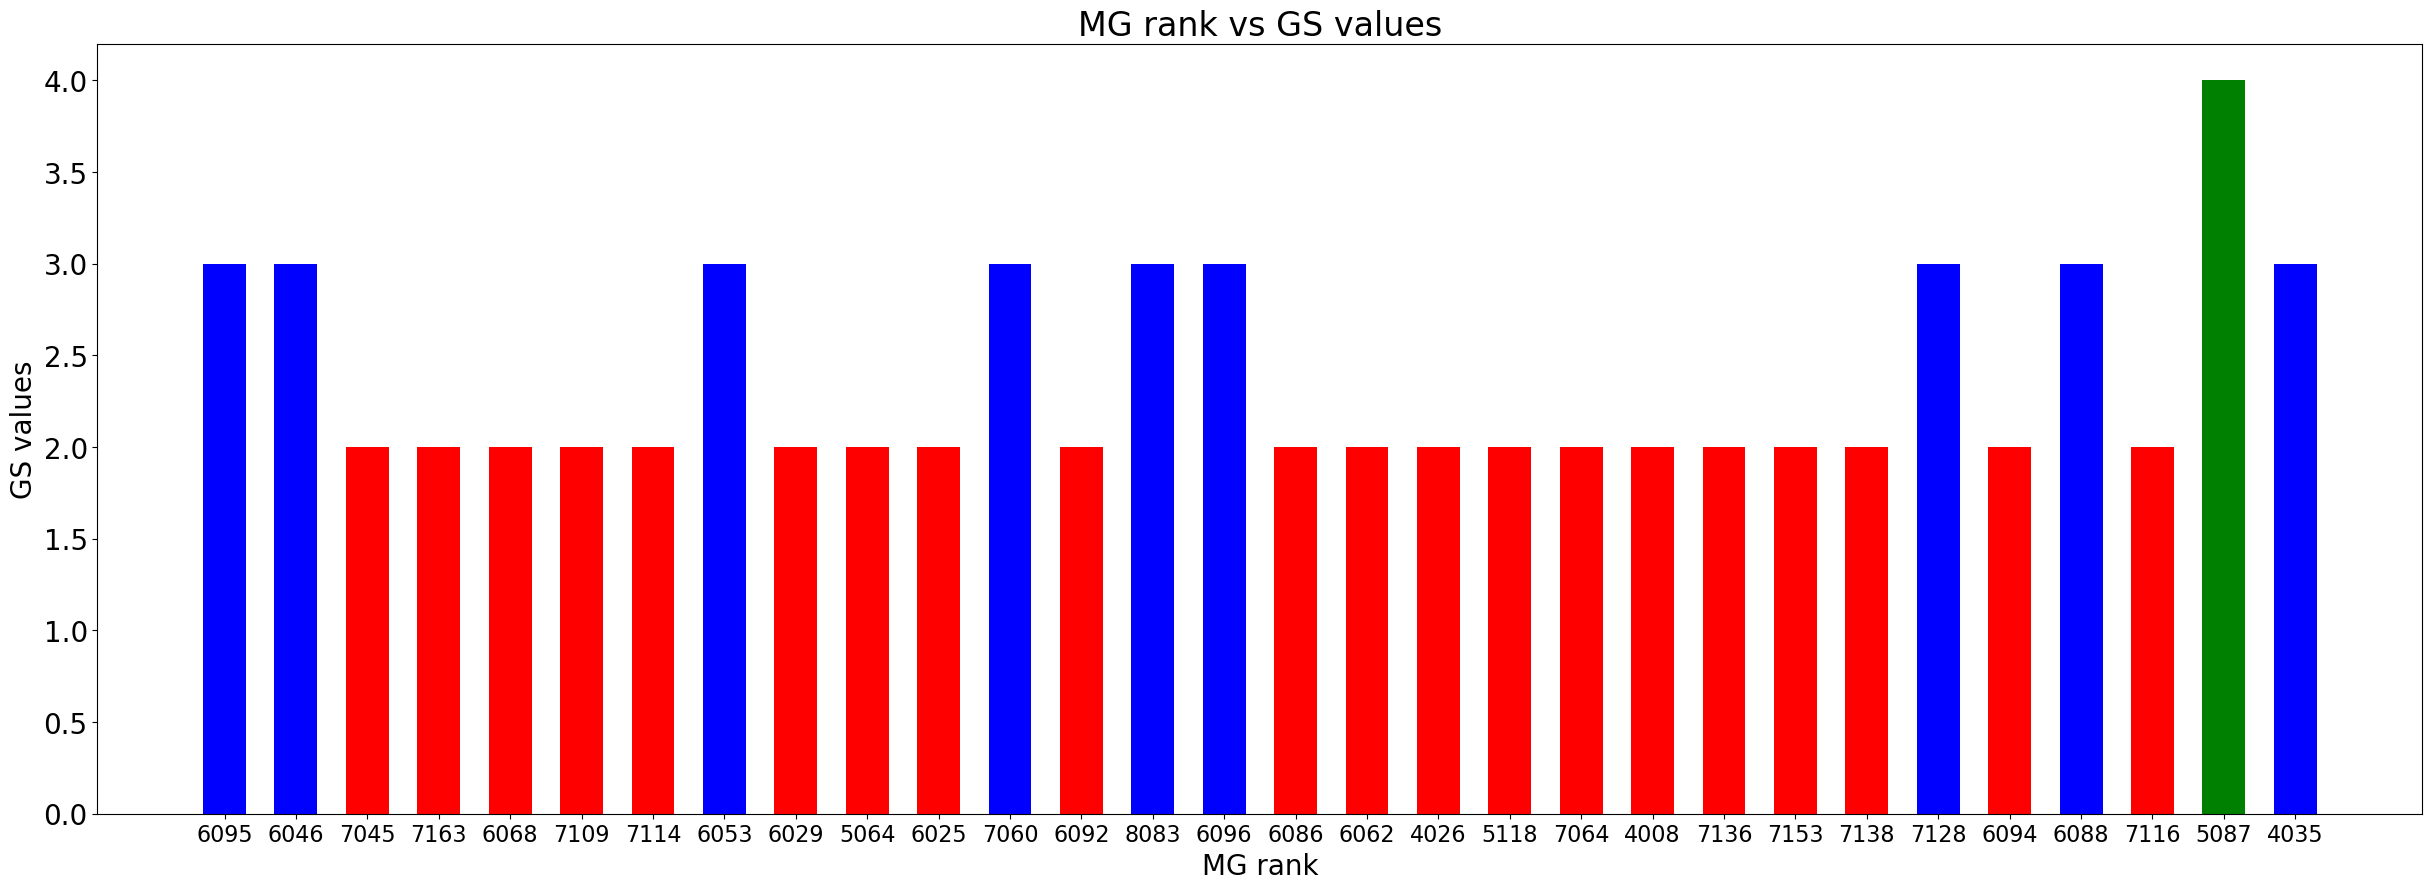

Cow order in matrix is:
[6096, 7114, 7116, 7045, 7060, 6025, 6092, 7128, 6088, 6094, 6086, 6046, 7163, 6062, 7109, 4026, 6095, 6029, 6053, 5064, 7064, 7138, 4008, 7153, 8083, 5087, 6068, 4035, 5118, 7136]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[26], [24], [23], [3], [7], [1], [19], [6], [0], [9], [10], [20], [16], [11], [5], [4], [28], [12], [22], [29], [13], [21], [17], [14], [18], [15], [8], [2], [25], [27]]
Sorted cows in ascending order is:
[[6068], [8083], [7153], [7045], [7128], [7114], [5064], [6092], [6096], [6094], [6086], [7064], [6095], [6046], [6025], [7060], [5118], [7163], [4008], [7136], [6062], [7138], [6029], [7109], [6053], [4026], [6088], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
199
    merge sorted  GS
0           6068   2
1           8083   3
2 

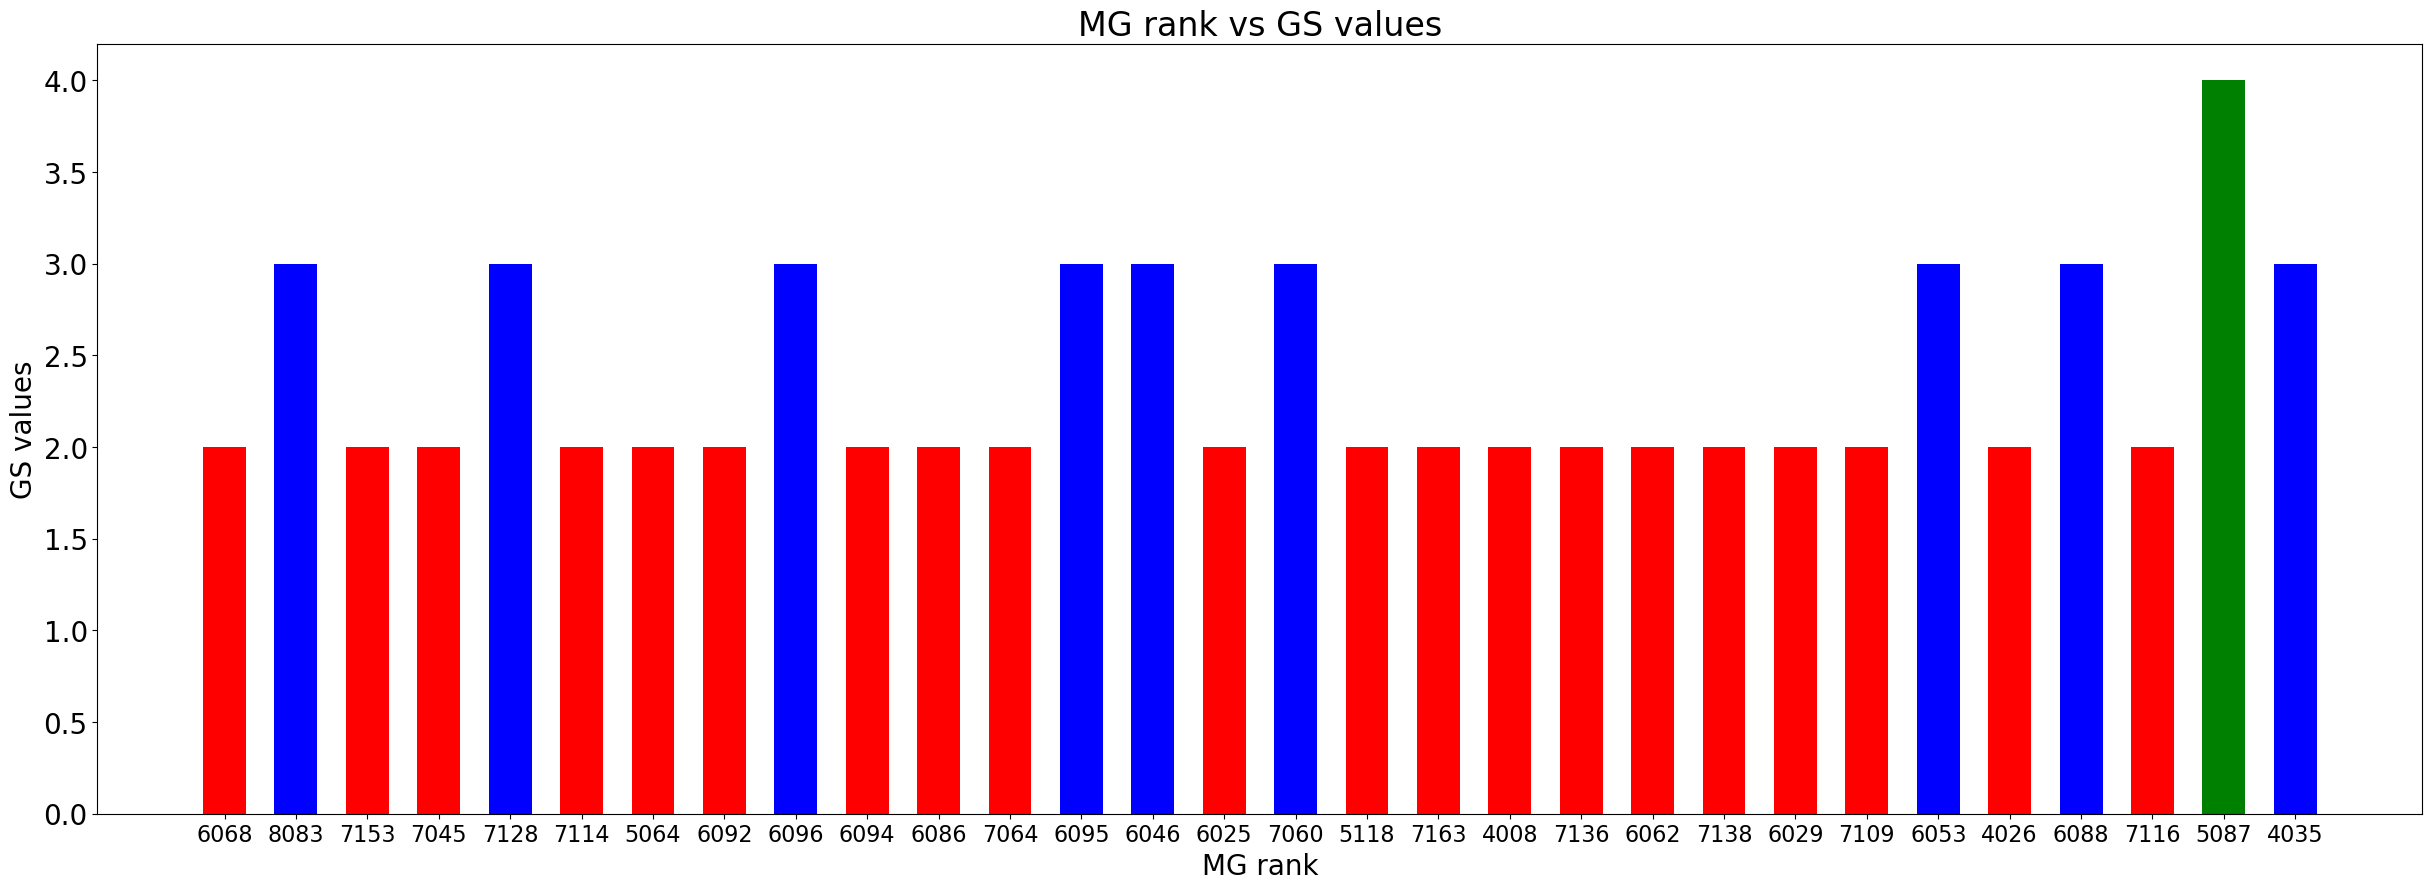

Cow order in matrix is:
[7109, 7045, 4026, 5118, 7060, 7064, 4008, 6025, 6046, 6092, 5087, 7163, 7136, 7128, 6053, 8083, 6086, 6029, 7116, 7114, 5064, 6095, 6068, 6088, 4035, 6096, 6062, 6094, 7138, 7153]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[8], [1], [11], [4], [22], [21], [28], [0], [5], [19], [17], [27], [7], [9], [2], [3], [15], [16], [6], [12], [13], [23], [20], [26], [25], [14], [29], [18], [10], [24]]
Sorted cows in ascending order is:
[[6046], [7045], [7163], [7060], [6068], [6095], [7138], [7109], [7064], [7114], [6029], [6094], [6025], [6092], [4026], [5118], [8083], [6086], [4008], [7136], [7128], [6088], [5064], [6062], [6096], [6053], [7153], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
216
    merge sorted  GS
0           6046   3
1           7045   2
2 

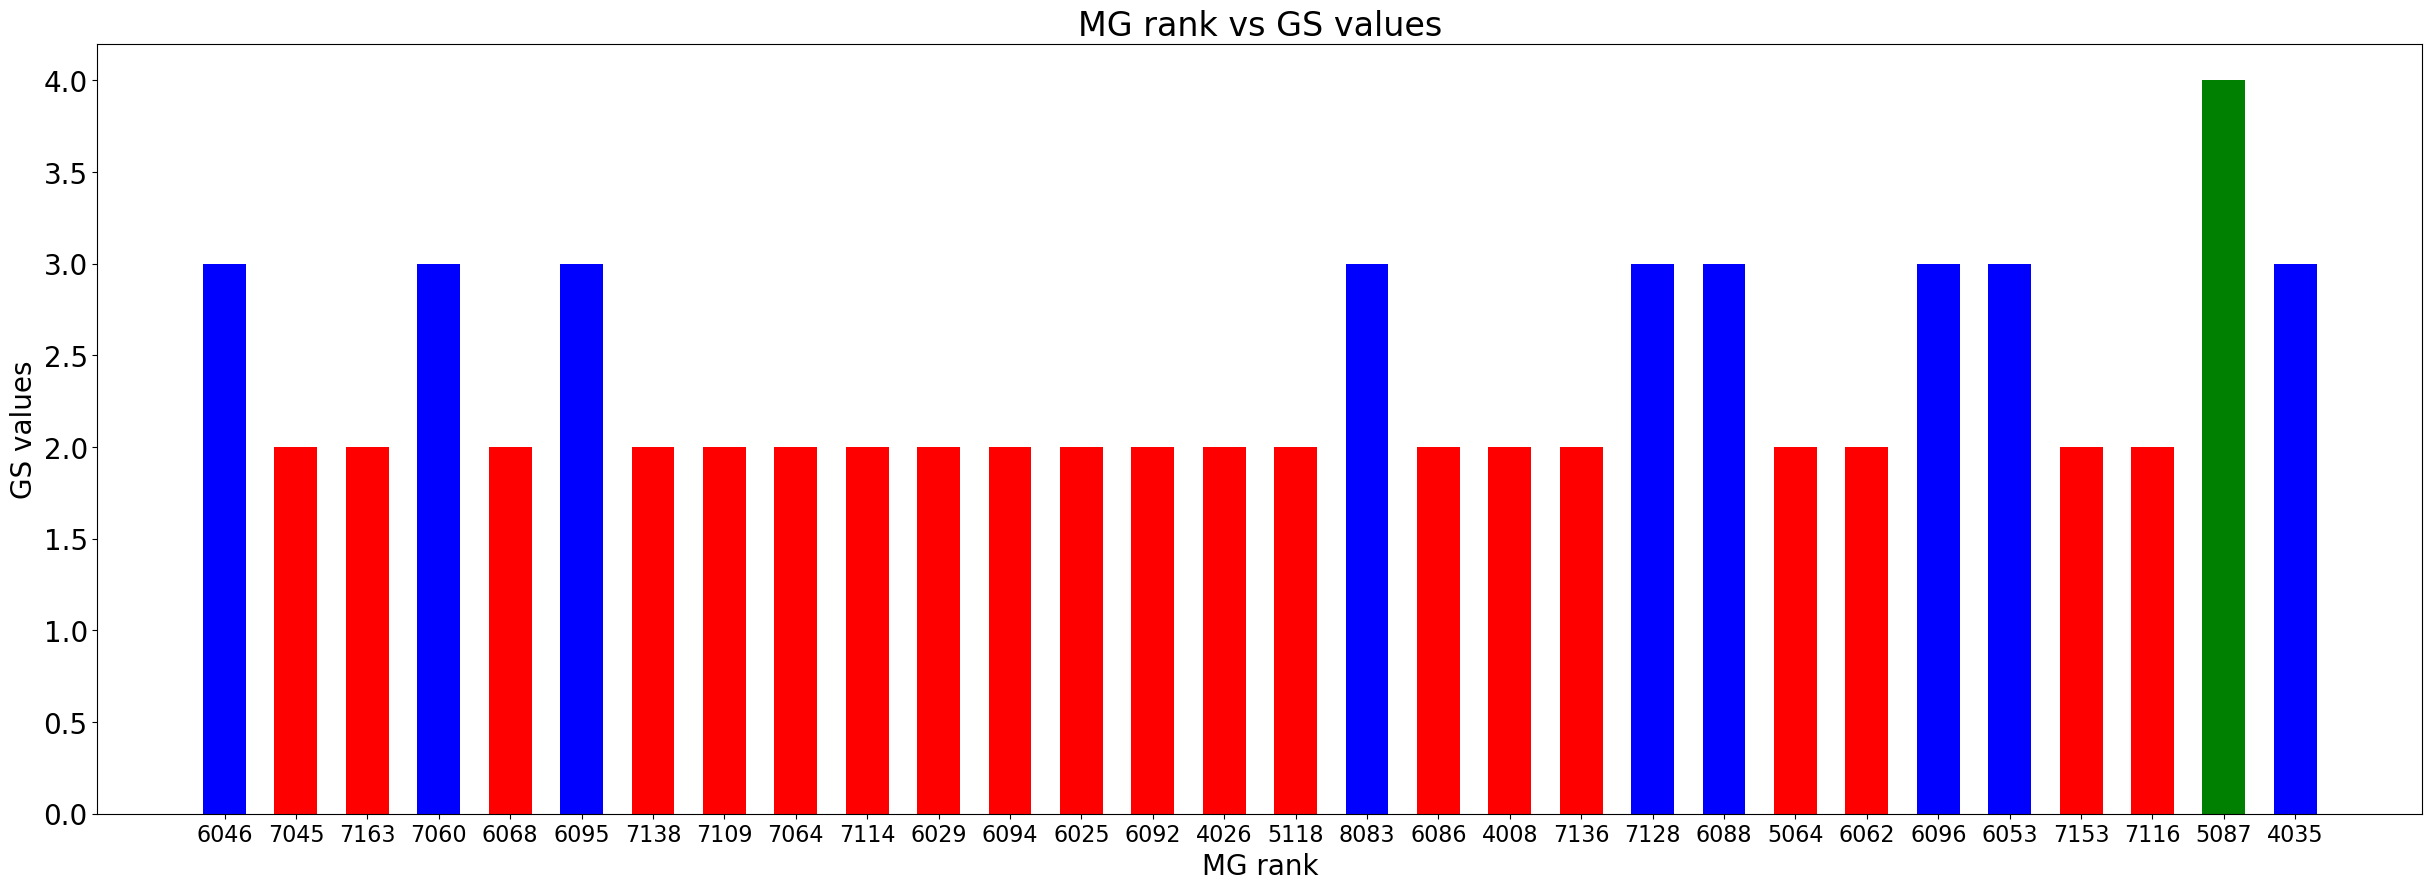

Cow order in matrix is:
[4008, 7163, 7138, 7060, 7064, 4026, 6088, 7153, 6068, 7109, 5064, 6053, 7045, 6092, 6095, 4035, 7114, 5087, 6094, 7128, 5118, 6025, 6062, 7116, 6086, 6046, 7136, 8083, 6096, 6029]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[9], [11], [20], [4], [25], [22], [2], [5], [27], [7], [12], [16], [29], [1], [3], [13], [28], [0], [26], [8], [24], [21], [6], [10], [19], [14], [23], [18], [17], [15]]
Sorted cows in ascending order is:
[[7109], [6053], [5118], [7064], [6046], [6062], [7138], [4026], [8083], [7153], [7045], [7114], [6029], [7163], [7060], [6092], [6096], [4008], [7136], [6068], [6086], [6025], [6088], [5064], [7128], [6095], [7116], [6094], [5087], [4035]]
Number of comparisons done in merge sort:
203
    merge sorted  GS
0           7109   2
1           6053   3
2 

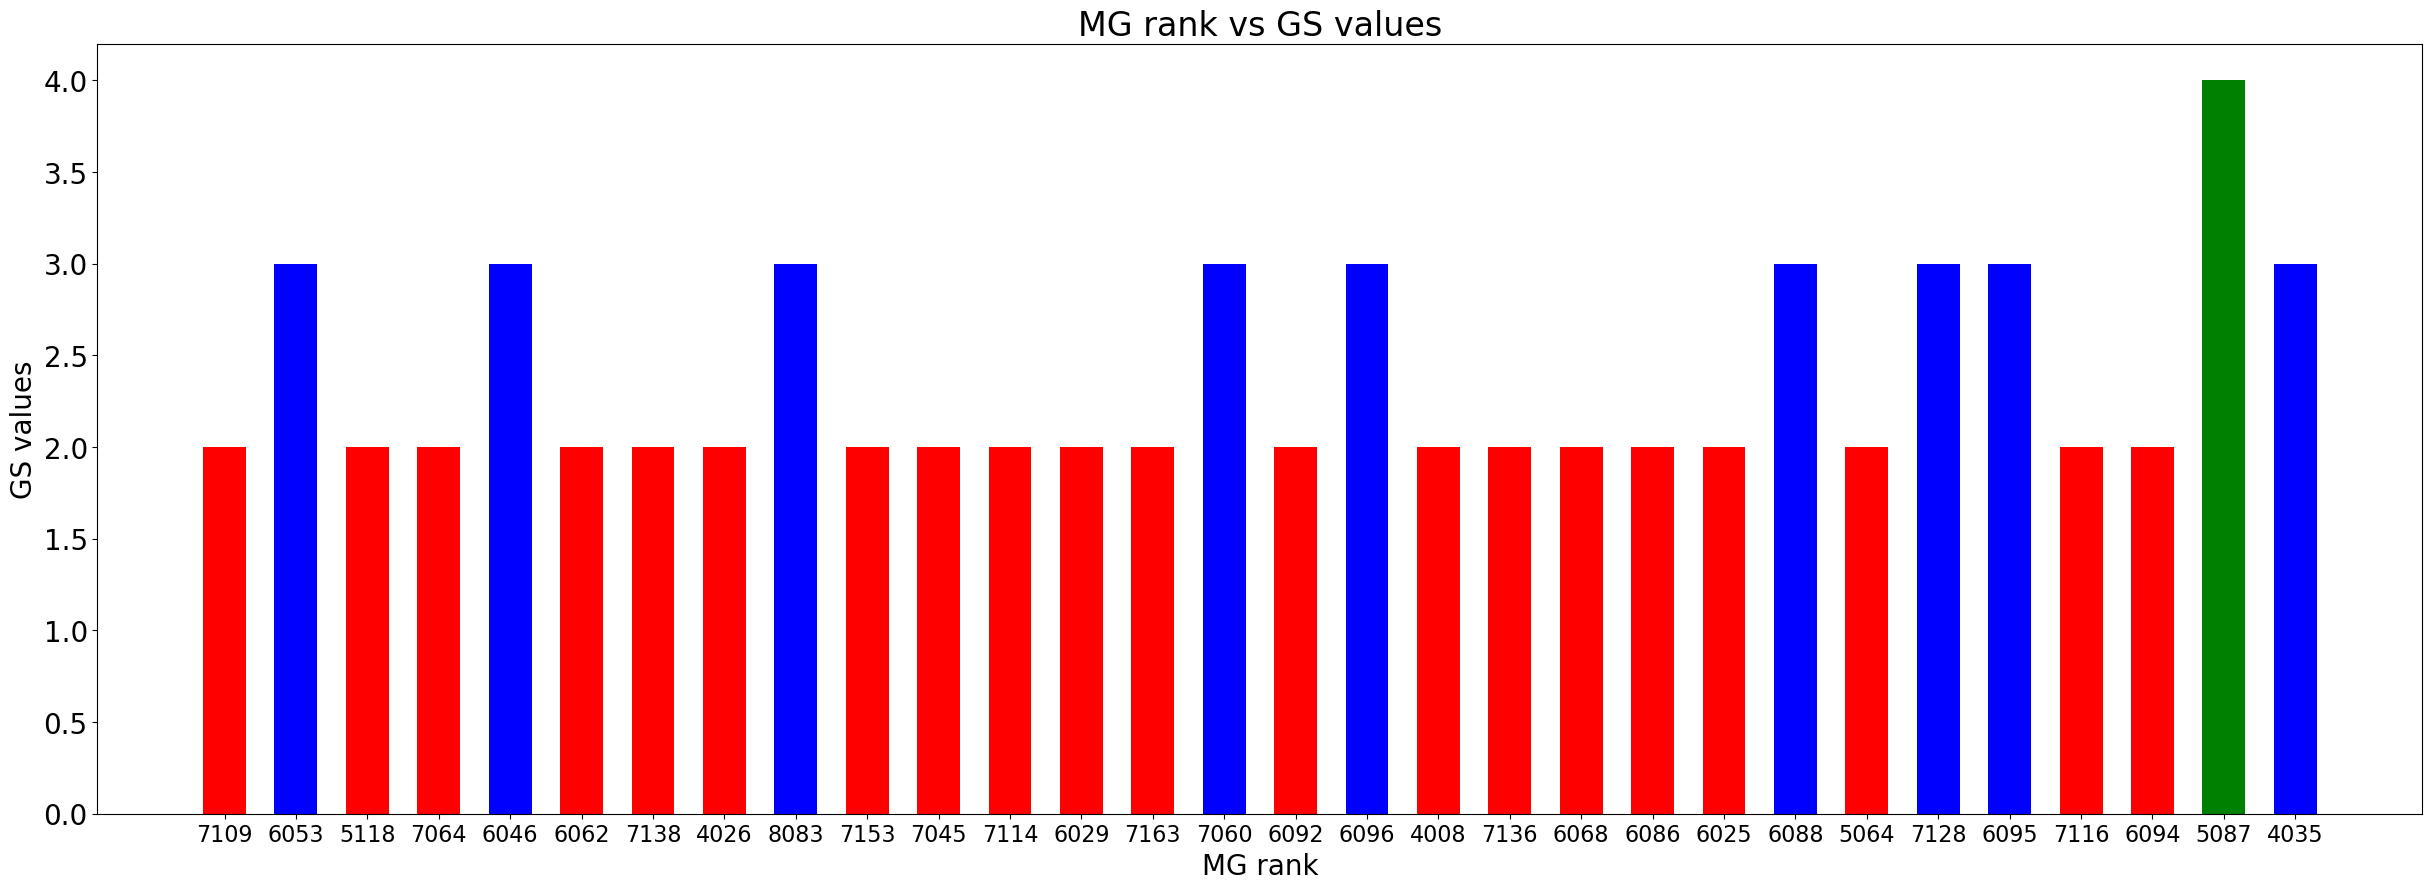

Cow order in matrix is:
[6029, 7045, 4026, 6068, 7114, 7138, 6094, 8083, 5118, 5087, 4035, 6053, 6086, 7163, 5064, 7064, 6088, 7128, 7116, 4008, 6025, 7136, 6046, 6096, 6062, 6092, 7153, 7109, 6095, 7060]
Basic array before mergesort:
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29]]
Basic array sorted after mergesort:
[[0], [22], [1], [13], [3], [6], [24], [25], [5], [23], [27], [12], [29], [11], [20], [2], [17], [4], [19], [21], [16], [14], [7], [26], [8], [15], [28], [18], [9], [10]]
Sorted cows in ascending order is:
[[6029], [6046], [7045], [7163], [6068], [6094], [6062], [6092], [7138], [6096], [7109], [6086], [7060], [6053], [6025], [4026], [7128], [7114], [4008], [7136], [6088], [5064], [8083], [7153], [5118], [7064], [6095], [7116], [5087], [4035]]
Number of comparisons done in merge sort:
213
    merge sorted  GS
0           6029   2
1           6046   3
2 

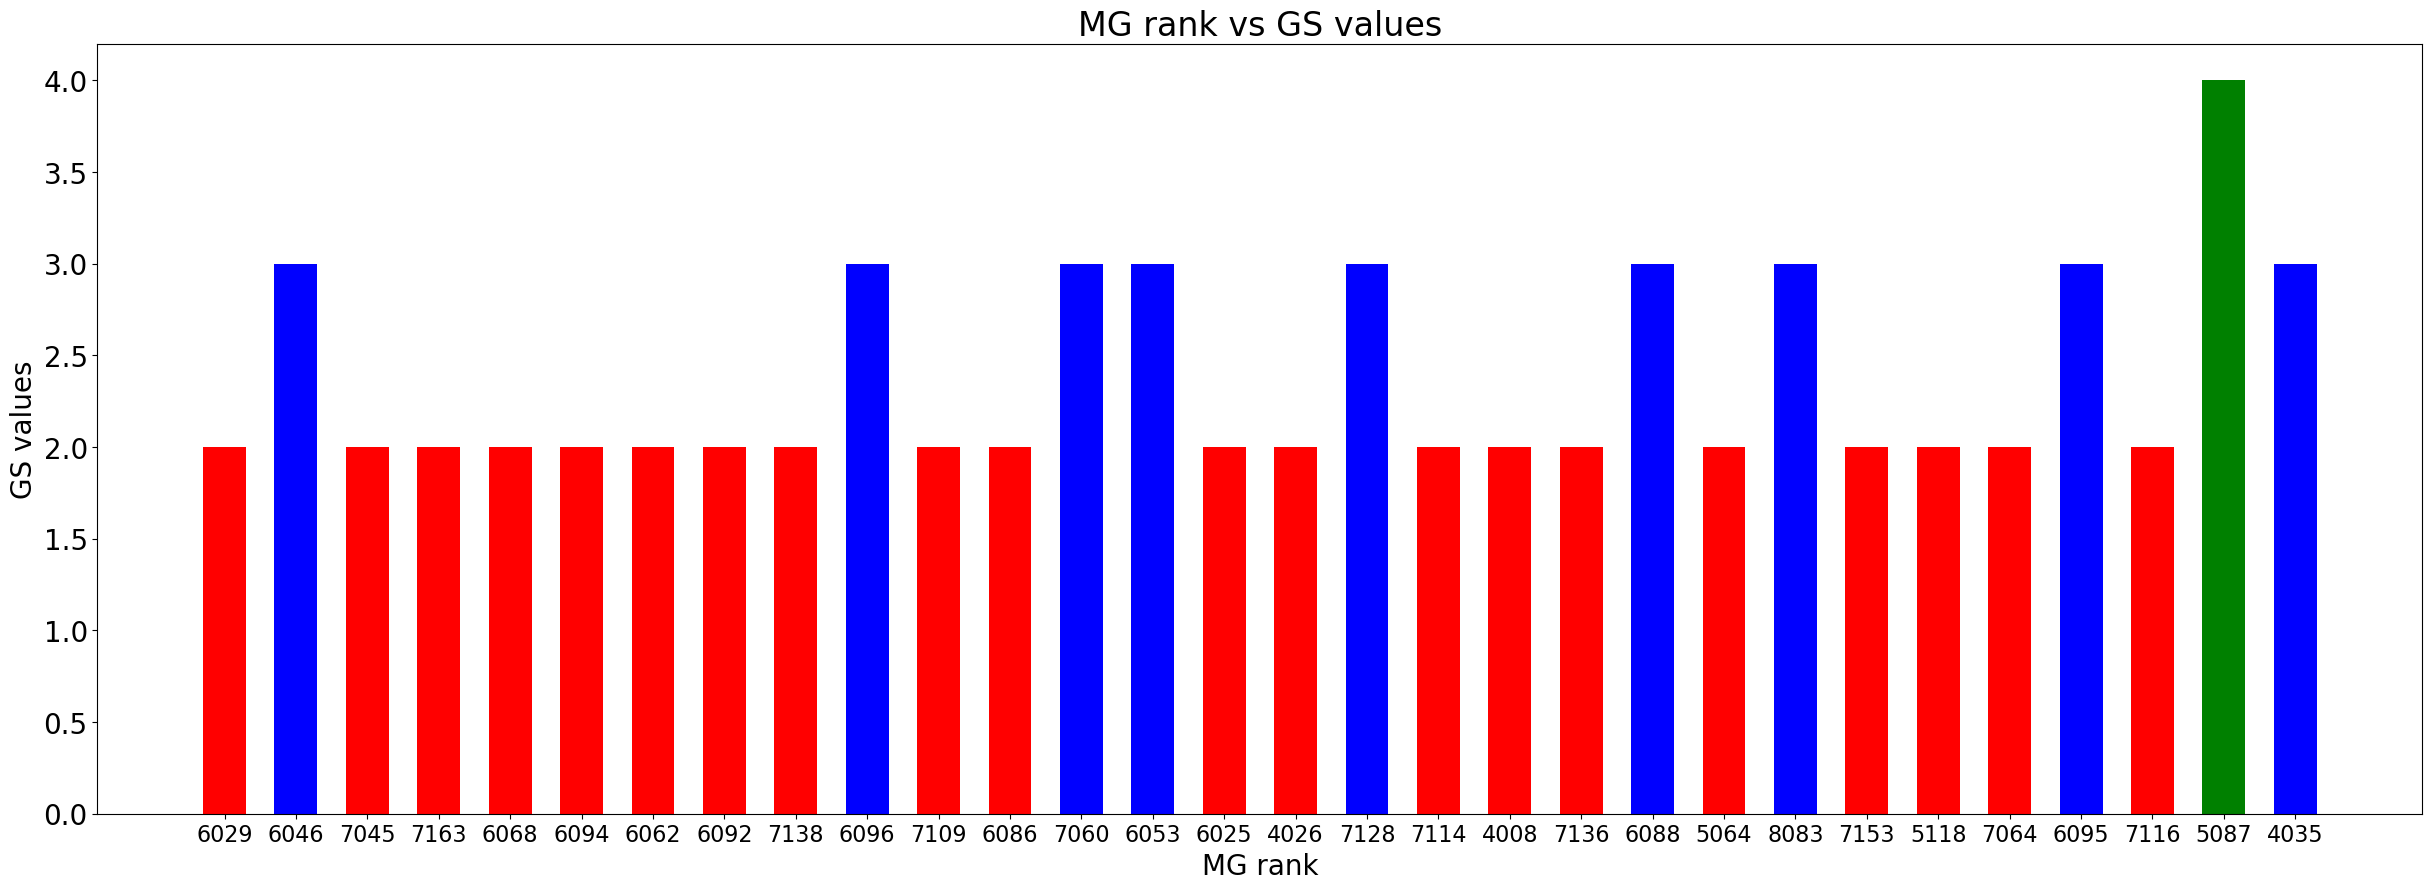

In [34]:
for j in range(10):
    data_comparison, new_cow_order = matrix_comparison(responses)
    #Applying MG
    num_cows=len(new_cow_order)
    print("Cow order in matrix is:")
    print(new_cow_order)

    lst_mg = []
    for i in range(num_cows):
        inner_list = []
        inner_list.append(i)
        lst_mg.append(inner_list)

    print("Basic array before mergesort:")
    print(lst_mg)

    comp_mg=0
    lst_mg,comp_mg= mergeSort(lst_mg,comp_mg,data_comparison)
    lst_mg,comp_mg=mergeSort(lst_mg,comp_mg,data_comparison)
    print("Basic array sorted after mergesort:")

    print(lst_mg)
    lst_mg_cows=[]
    while (len(lst_mg)>0):
        aux_len=len(lst_mg[0])
        aux_ties=[]
        for i in range(aux_len):
            aux_ties.append(new_cow_order[lst_mg[0][i]])
        lst_mg.pop(0)
        lst_mg_cows.append(aux_ties)
    print("Sorted cows in ascending order is:")
    print(lst_mg_cows)

    print("Number of comparisons done in merge sort:")
    print(comp_mg)
    # Making comparison with GS value
    mg_vs_GS = pd.DataFrame([item for sublist in lst_mg_cows for item in sublist], columns=['merge sorted'])
    N=mg_vs_GS.shape[0]
    aux=[]
    for i in range (N):
        cow=mg_vs_GS.at[i,'merge sorted']
        aux.append(list(df_3.loc[df_3['Cow']== cow,'GS'])[0])
    mg_vs_GS['GS'] = aux
    print(mg_vs_GS)
    #Plotting results
    import matplotlib.pyplot as plt
    x=list(mg_vs_GS['merge sorted'])
    y=list(mg_vs_GS['GS'])
    string_cow = [str(item) for item in x]
    # Get unique y-axis values
    unique_values = np.unique(y)

    # Define the colors for each unique y-axis value
    colors = {'2': 'red', '3': 'blue', '4': 'green'}

    plt.figure(figsize=(30, 10))

    plt.bar(string_cow, y, color=[colors[str(val)] for val in y], width=0.6)

    plt.xlabel('MG rank', fontsize=20)
    plt.ylabel('GS values', fontsize=20)
    plt.title('MG rank vs GS values', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=20)
    plt.show()
